In [1]:
import numpy as np
from torchvision import datasets
from torchvision.transforms import ToTensor

# Load the USPS dataset
usps_train = datasets.USPS(root='usps', download=True, transform=ToTensor(), train=True)

# Extract the first 100 samples for labels 1 and 8
images, labels = [], []
for img, label in usps_train:
    if label == 1 and len([l for l in labels if l == 1]) < 100:
        images.append(img.numpy().squeeze())  
        labels.append(1)
    elif label == 8 and len([l for l in labels if l == 8]) < 100:
        images.append(img.numpy().squeeze())
        labels.append(0)  
    if len(labels) == 200:  
        break

# Convert lists to NumPy arrays
images = np.array(images)  
labels = np.array(labels)  

print(f"Dataset shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


Dataset shape: (200, 16, 16)
Labels shape: (200,)


In [2]:
conv_kernel = np.random.randn(5, 5) * 0.1  # Random 5x5 kernel
fc_weight = np.random.randn(12 * 12) * 0.1  # Fully connected weights (144 elements)
fc_bias = 0.0  # Fully connected bias

def relu(x):
    """ReLU activation function."""
    return np.maximum(0, x)

def sigmoid(x):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-x))

def forward(image):
    """Forward pass through the CNN."""
    # Convolutional layer
    conv_out = np.zeros((12, 12))
    for i in range(12):
        for j in range(12):
            conv_out[i, j] = np.sum(image[i:i+5, j:j+5] * conv_kernel)
    
    # ReLU activation
    relu_out = relu(conv_out)
    
    # Flatten layer
    flatten_out = relu_out.flatten()
    
    # Fully connected layer
    logits = np.dot(flatten_out, fc_weight) + fc_bias
    prediction = sigmoid(logits)  # Output probability
    
    return prediction, relu_out, conv_out, flatten_out


In [3]:
def backward(image, label, prediction, relu_out, conv_out, flatten_out):
    """Backward pass using simplified gradient computation."""
    d_loss = prediction - label  

    # Gradients for fully connected layer
    d_fc_weight = d_loss * flatten_out  
    d_fc_bias = d_loss  

    # Gradients for ReLU output
    d_relu = d_loss * fc_weight.reshape(12, 12)  
    d_relu[conv_out <= 0] = 0  

    # Gradients for convolutional kernel
    d_kernel = np.zeros_like(conv_kernel)
    for i in range(12):
        for j in range(12):
            d_kernel += image[i:i+5, j:j+5] * d_relu[i, j]

    return d_fc_weight, d_fc_bias, d_kernel


In [4]:
# Training parameters
learning_rate = 0.1
epochs = 80
losses = [] 

# Training loop
for epoch in range(epochs):
    epoch_loss = 0.0  
    
    for img, label in zip(images, labels):
        # Forward pass
        prediction, relu_out, conv_out, flatten_out = forward(img)
        
        # Compute binary cross-entropy loss
        loss = -label * np.log(prediction + 1e-7) - (1 - label) * np.log(1 - prediction + 1e-7)
        epoch_loss += loss  
        
        # Backward pass
        d_fc_weight, d_fc_bias, d_kernel = backward(img, label, prediction, relu_out, conv_out, flatten_out)
        
        # Update parameters
        global fc_weight, fc_bias, conv_kernel
        fc_weight -= learning_rate * d_fc_weight
        fc_bias -= learning_rate * d_fc_bias
        conv_kernel -= learning_rate * d_kernel
    
    # Compute and store average loss for the epoch
    avg_loss = epoch_loss / len(images)
    losses.append(avg_loss)

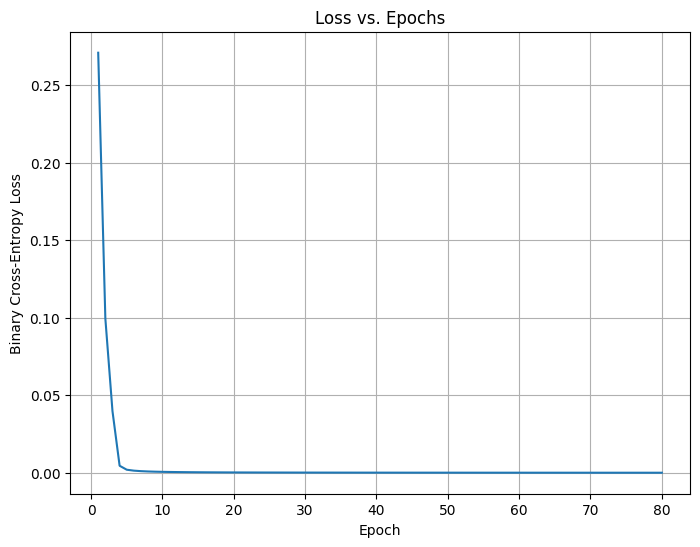

In [5]:
import matplotlib.pyplot as plt

# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), losses)
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.grid()
plt.show()

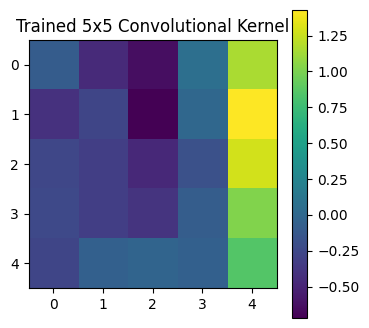

In [6]:
# Display the trained convolutional kernel
plt.figure(figsize=(4, 4))
plt.imshow(conv_kernel, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Trained 5x5 Convolutional Kernel')
plt.show()